In [1]:
import numpy as np
import matplotlib.pyplot as plt
import radio_beam
from radio_beam import Beam
from spectral_cube import SpectralCube
from matplotlib import cm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from matplotlib.patches import Ellipse
from astropy import units as u 
from astropy import coordinates
from astropy.utils import data
#import pylab as pl
from astropy.io import ascii
from matplotlib import rcParams
#import aplpy
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as mtick

Useful constants for HI


In [2]:
restfr=1420.405*10**6 #HI rest frequency in HZ 
H0=67.5 #Hubble constant
c=299792 #speed of light

Open your data cube in ds9. Scroll through it, do you see the butterfly diagram and channel maps? What do you think is the central frequency of the source? 

Now read the data here using the Spectral cube package

In [3]:
cube_name='J100236.5+014618'
freq=1.376381*10**9 # central frequency of the source in the cubelet
cubelet=SpectralCube.read('/Users/apple/Documents/GitHub/Mphys_HI/COSMOS_r0p5/'+str(cube_name)+'.r0p5.fits')


Explore dimensions of the cubelet: Third axis is Frequency in Hz and has 12 channels. What is the spectral resolution of the cubelet in Hz? 

In [4]:
cubelet

SpectralCube with shape=(15, 100, 100) and unit=Jy / beam:
 n_x:    100  type_x: RA---SIN  unit_x: deg    range:    34.405030 deg:   34.460268 deg
 n_y:    100  type_y: DEC--SIN  unit_y: deg    range:    -5.325284 deg:   -5.270279 deg
 n_s:     15  type_s: FREQ      unit_s: Hz     range: 1374917740.274 Hz:1377843541.819 Hz

by knowing the spectral resolution can you verify the central frequency of your source? (channel 7)

You can explore the header of the cubelet. The intensity unit is in Jy/beam. BMAJ and BMIN are the major and mnior axis of the PSF/beam

In [5]:
cubelet.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                   15                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'J0217-0449'                                                          
BUNIT   = 'beam-1 Jy'          / Brightness (pixel) unit                        
ALTRVAL =   1.904003154951E+07 /Alternate frequency reference value             
ALTRPIX =   1.000000000000E+00 /Alternate frequency reference pixel             
VELREF  =                  257 /1 LSR, 2 HEL, 3 OBS, +256 Radio                 
COMMENT casacore non-standar

Then you can read the parameters which you will need from the HEADER

In [5]:
bmaj=cubelet.header['BMAJ']*3600 # values in the header are in degrees, so we need to convert them to arcsec
bmin=cubelet.header['BMIN']*3600
bpa=cubelet.header['BPA']
dpix=cubelet.header['CDELT2']*3600 #amount of arcsec per pixel
df=cubelet.header['CDELT3'] #hz
print(bmaj,bmin,df)

16.002957041729758 16.002957041729758 26125.31243753


CDELT3 is the spectral resoltuion. Did you get it right? bpa is the orientation of the BEAM/PSF;
dpix is the size of the pixel in arcsec


Now we need to calcualte a couple of parameters which you saw in the lecture, which are useful for HI mass calculation

In [6]:
#Parameters to convert your flux from Jy/beam to Jy
omega = (np.pi*(bmaj/206265)*(bmin/206265))/(4*np.log(2))*4.25*10**10 # beam area in arcsec
bmpix=dpix**2/omega # amount of pixels per beam area- convertion factor, we will see it used later
print(bmpix)
#Formulas from the lecture
V=(restfr**2-freq**2)/(restfr**2+freq**2)*c # systemic velocity
dist=V/H0           #distance Mpc
z=(restfr-freq)/freq # redshift

#Convert cahnnel width from HZ to km/s
dv=(((restfr**2-(freq-df)**2)/(restfr**2+(freq-df)**2)*c))-V #channel width in km/s

print(dv) # check that all values make sence

0.013799328050989369
5.684814442656716


Now we can convert the entire Frequency axis to velocity

In [7]:
cubelet = cubelet.with_spectral_unit(u.km/u.s,
                                       velocity_convention='radio',
                                       rest_value=1.420405*u.GHz)

Next we can calculate the spectrum of the whole cubelet. Spectrum is the sum of all intensitties in the channel 

In [9]:
# First we calculate spectrum in original units Jy/beam
spectrum = cubelet.sum(axis=(1,2)) #sum of all pixel values in one channel
# Then we use parameter "bmpix" to convert from Jy/beam to Jy 
spectrum_jy= spectrum*bmpix

In [10]:
#lets look at the values
print(spectrum_jy)

[-7.57347828e-04  2.96761230e-05 -2.79728495e-03 -7.38828899e-04
  1.01654908e-03  1.32793665e-03  4.03364576e-03  2.42123428e-03
  4.11329121e-03 -7.85974311e-04 -3.21041250e-03 -3.66915198e-03
 -3.47672621e-03 -2.70731637e-03 -1.72097687e-04] Jy / beam


In order to plot our global HI profile we need to look at spectrum a a function of velocity. We can derive velocity array from the cubelet

In [18]:
v_arr1 = cubelet.spectral_axis.value
print(v_arr1)

[13310.44961213 13304.93557097 13299.42152981 13293.90748865
 13288.39344749 13282.87940633 13277.36536518 13271.85132402
 13266.33728286 13260.8232417  13255.30920054 13249.79515938
 13244.28111822 13238.76707707 13233.25303591 13227.73899475
 13222.22495359 13216.71091243 13211.19687127 13205.68283012
 13200.16878896 13194.6547478  13189.14070664 13183.62666548
 13178.11262432 13172.59858317 13167.08454201 13161.57050085
 13156.05645969 13150.54241853 13145.02837737 13139.51433621
 13134.00029506 13128.4862539  13122.97221274 13117.45817158
 13111.94413042 13106.43008926 13100.91604811 13095.40200695
 13089.88796579 13084.37392463 13078.85988347 13073.34584231
 13067.83180115 13062.31776    13056.80371884 13051.28967768
 13045.77563652 13040.26159536 13034.7475542  13029.23351305
 13023.71947189 13018.20543073 13012.69138957 13007.17734841
 13001.66330725 12996.14926609 12990.63522494 12985.12118378
 12979.60714262 12974.09310146 12968.5790603  12963.06501914
 12957.55097799 12952.03

Now examine the spectrum by plotting it. You can also save the plot. 

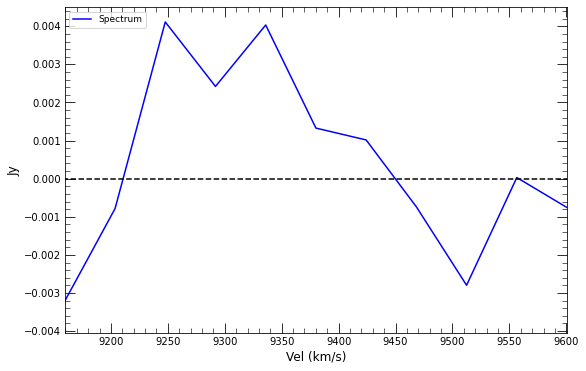

In [15]:
plt.figure(figsize=(9,6))
plt.plot(v_arr1, spectrum_jy, 'b-', label='Spectrum')
plt.plot([800, 20700], [0, 0],'k--')
plt.xlim(v_arr1[10],v_arr1[0])
plt.xlabel('Vel (km/s)', fontsize = 12)
plt.ylabel('Jy', fontsize = 12)


plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().tick_params(axis='both', which='major', direction='in', length=10, top=True, right=True)
plt.gca().tick_params(axis='both', which='minor', direction='in', length=5, top=True, right=True)

plt.legend(loc=2, numpoints=1, prop={'size':9})

#plt.savefig('/Users/ponomareva/Desktop/MGHT_AA.pdf',format = 'pdf', bbox_inches = 'tight', transparent=True)
plt.show()

What can you say about the source? What is it systemic velocity?

This Spectrum includes a lot of noise around the source, which affects the values and the shape of global HI profile. In order to get rid of the noise and obtain the true spectrum of the source only we need to do couple of more procedures

However, our resolution is high, it means that some emission of the source can be burried below the noise. In order to bring the noise down and emission up we need to smooth our cubelet to lower special resolution and to create a mask

In [9]:
# we define the new beam, which is 20 x 20 arcsec
beam = radio_beam.Beam(major=20*u.arcsec, minor=20*u.arcsec, pa=0*u.deg)
#then we convolve our original cubelet with the new beam
cube_20 = cubelet.convolve_to(beam)

Next, we need to calculate the rms and 1 sigma of the new smoothed cube, in order to clip it and keep only the emission above 3 sigma, which is the true signal. That way we get rid of the noise.

In [231]:
#first we define the region of the new cube which is emission free, and has only noise
# the order here is [z,y,x]= [freq, dec,ra] I checked in advance that this region is signal free
subcube_20=cube_20[:,85:120,75:100]

rms = subcube_20.std(axis=(1,2))
sigma=np.mean(rms.value)
print(sigma)

5.2191390107527006e-05


In [233]:
print(cube_20)

SpectralCube with shape=(15, 100, 100) and unit=Jy / beam:
 n_x:    100  type_x: RA---SIN  unit_x: deg    range:    34.405030 deg:   34.460268 deg
 n_y:    100  type_y: DEC--SIN  unit_y: deg    range:    -5.325284 deg:   -5.270279 deg
 n_s:     15  type_s: VRAD      unit_s: km / s  range:     8983.075 km / s:    9600.598 km / s


Next we create a mask, i.e. clipping the noise out of the smoothed cubelet and keep only signal above 3 sigma.

In [60]:
sigma=14e-05
include_mask = cube_20 > 3*sigma*cube_20.unit
mask_cube = cube_20.with_mask(include_mask)
#you can save the mask and examine it in ds9 
mask_cube.write('/Users/apple/Documents/GitHub/Mphys_HI/COSMOS_r0p5/'+str(cube_name)+'_revised_masked_cube.fits', format='fits',overwrite='True')
# derive new spectrum
spectrum_new_jy = mask_cube.sum(axis=(1,2))*bmpix
spectrum_new_jy_converted = np.nan_to_num(spectrum_new_jy.value)

Then we can apply this mask to the original cubelet of high resolution. This way we can keep and high resolution and include the low column density emission
however this does not work well, so we are just plotting the masked cube

Now we can calculate the spectrum of the masked cubelet, where only emission of the source is present and no noise.

Let's plot both: spectrum from the original cubelet and spectrum from the masked one

70


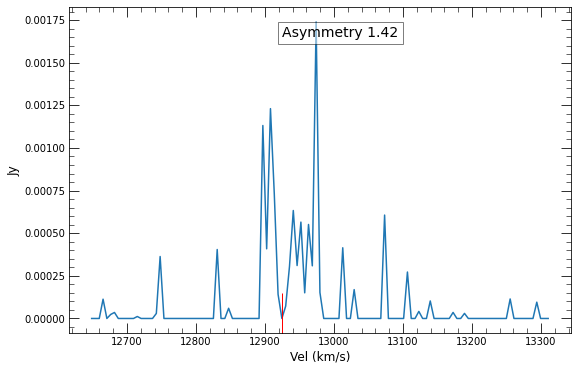

In [65]:


#calculate asymmetry and store --------------------------------------
#asymmetry ratio calculation
left_sum=0
right_sum=0
#spectrum for 2,3,4,5 1=[0,8,14]2=[3,5,9] 3=[0,6,14] 4=[5,11,14] 5=[9,13,14]
i_begin = 0


spec_center=-10

i_mid = int(len(v_arr1)/2)-spec_center
i_end = int(len(v_arr1))


for i in range(i_begin,i_mid):
    left_sum=spectrum_new_jy_converted[i]+left_sum
for i in range(i_mid,i_end):    
    right_sum=spectrum_new_jy_converted[i]+right_sum


asymmetry = round(left_sum/right_sum,2)


# examine the spectrum
plt.figure(figsize=(9,6))
plt.plot(v_arr1, spectrum_new_jy_converted)
#plt.plot(v_arr1, spectrum_jy, label='Spectrum_unmasked')
#plt.plot([800, 25700], [0, 0],'k--')
print(i_mid)

plt.plot(v_arr1[i_mid], spectrum_new_jy_converted[i_mid], 'r|', markersize=50)

plt.xlabel('Vel (km/s)', fontsize = 12)
plt.ylabel('Jy', fontsize = 12)

x_pos = 0.97 * (v_arr1[72] - v_arr1[0]) + v_arr1[0]  # 10% into the x-range
y_pos = 0.95 * (max(spectrum_new_jy_converted) - min(spectrum_new_jy_converted))  # 10% into the y-range

x_pos_ = 0.97 * (v_arr1[72] - v_arr1[0]) + v_arr1[0]  # 10% into the x-range
y_pos_ = 0.85 * (max(spectrum_new_jy_converted) - min(spectrum_new_jy_converted))  # 10% into the y-range

plt.text(x_pos, y_pos, 'Asymmetry ' +str(asymmetry), fontsize=14, bbox=dict(facecolor='white', alpha=0.5))


plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().tick_params(axis='both', which='major', direction='in', length=10, top=True, right=True)
plt.gca().tick_params(axis='both', which='minor', direction='in', length=5, top=True, right=True)

#plt.legend(loc=2, numpoints=1, prop={'size':12})

plt.savefig('/Users/apple/Documents/GitHub/Mphys_HI/COSMOS_r0p5_spectrum/'+str(cube_name)+'_spectrum.pdf',format = 'pdf', bbox_inches = 'tight', transparent=True)

plt.show()


As you see spectrum from the masked cube is different. Can you think about what changed and why? Does it look more like global HI profile now? 

What is the width of the global HI profile (blue) in km/s, what this width means? 

Do you see the importance of masking when you work with HI data 

Now, lets calculate the HI mass

In [240]:
#First lets derive the total flux, which is the integrated flux under HI profile:
flux_total=np.sum(spectrum_new_jy_converted)
print(spectrum_new_jy_converted)
#Next, calculate flux density by multiplying to channel width in km/s
fluxdens=flux_total*dv 
print(flux_total)
# Then we created all the ingredients to calculate the HI mass
MHI=2.356*10**5*dist**2*fluxdens
print(MHI/10**10,np.log10(MHI))

[0.00000000e+00 6.81810916e-05 8.80531801e-04 2.40691338e-04
 1.03310009e-03 1.32246583e-03 9.30143505e-03 9.97533279e-03
 4.13207356e-03 5.46623136e-04 3.39216193e-04 4.59633948e-04
 0.00000000e+00 8.43315243e-04 2.13744109e-03]
0.031280041174779
0.6549062341469025 9.816179124560291


The HI mass of our galaxy is 1.8*10^10 M_solar. Use the lecture, in order to estimate the HI dimater of this galaxy

Next, lets look in more detail on HI distribution

Lets look at HI distribution within the galaxy by creating the moment 0 or HI intensity map

In [241]:
moment_0 = mask_cube.moment(order=0) 
moment_0.hdu  #it is important so you can use coordinates for the plots

In [242]:
#convert your map to column densities in atoms/cm^2
atoms=(1.1*10**24*((moment_0)/(bmaj*bmin)))

How can you convert from atoms to surface mass densities?

You can visualize your map in order to examine the  HI morphology

<ipython-input-243-7d6dc5cc27ab>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("plasma"))
  cmap.set_bad('white')


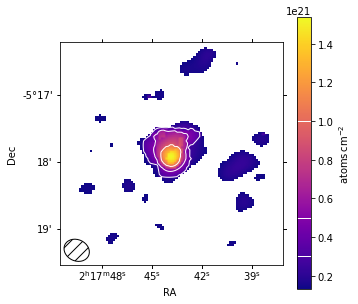

In [243]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111,projection=atoms.wcs)
cmap = cm.plasma
cmap.set_bad('white')
im = ax.imshow(atoms.value,origin='lower', cmap=cmap)
contours = ax.contour(atoms.value,levels=( 1e20,3e20,5e20,1e21,2E21), colors=['white'], linewidths=1)

ax.set_xlabel("RA ", fontsize=10)
ax.set_ylabel("Dec", fontsize=10)
cb = plt.colorbar(mappable=im)
cb.set_label(r'${\rm atoms}\,{\rm cm}^{-2}$')
cb.add_lines(contours)
el = Ellipse((7, 6), bmaj, bmin,angle=bpa, edgecolor='black',hatch='//', facecolor='none')
ax.add_patch(el)
#plt.savefig('/Users/apple/Astro/revised_HI/'+str(cube_name)+'_revised_HI.png',format = 'png',\
#             bbox_inches = 'tight', transparent=True)
plt.show()

What do you see? Is it a regular disk? Or is it disturbed? Does it have a companion? What environment do you think this galaxy lives in?

Next, lets look at its velocity map

In [244]:
moment_1=mask_cube.moment(order=1)
moment_1.hdu

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


/Users/apple/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


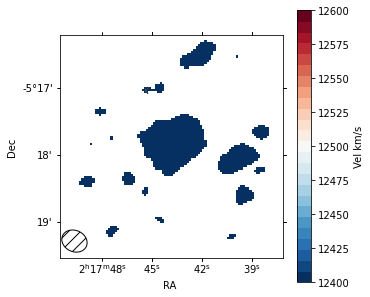

In [245]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111,projection=atoms.wcs)
#cmap = cm.RdBu_r
cmap=plt.get_cmap('RdBu_r',25)
#cmap.set_bad('white')
im = ax.imshow(moment_1.value,origin='lower', cmap=cmap, vmin=12400, vmax=12600)

contours = ax.contour(moment_1.value,levels=(83,15300,15350), colors=['white'], linewidths=1)
contours1 = ax.contour(moment_1.value,levels=(8325, 8325.2), colors=['black'], linewidths=1)
ax.set_xlabel("RA ", fontsize=10)
ax.set_ylabel("Dec", fontsize=10)
cb = plt.colorbar(mappable=im)
cb.set_label(r'Vel km/s')
#cb.add_lines(contours)
#cb.add_lines(contours1)
#cb.add_lines(contours)

el = Ellipse((6, 7), bmaj, bmin,angle=bpa, edgecolor='black',hatch='//', facecolor='none')
ax.add_patch(el)
#ax.invert_yaxis()  # Flips the Y axi
#plt.savefig('/Users/apple/Astro/revised_velocity/'+str(cube_name)+'_revised_velocity.png',format = 'png',\
 #            bbox_inches = 'tight', transparent=True)
plt.show()

Is this gaalxy regularly rotating? what side rotates towards you (approaching) and what rotates away from you (receding)? What is the approximate position angle of this the galaxy? And Systemic velocity? Does the companion have the same systemic velocity or higher/lower? What does it say about their distances? What is the distance between them? 

In [246]:
moment_2=mask_cube.linewidth_sigma()  
moment_2.hdu

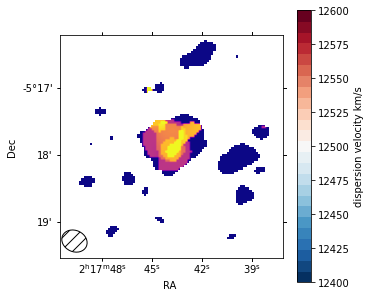

In [247]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111,projection=atoms.wcs)

#contours = ax.contour(atoms.value,levels=( 10,20,30,40,50), colors=['white'], linewidths=1)
ax.set_xlabel("RA ", fontsize=10)
ax.set_ylabel("Dec", fontsize=10)
cb = plt.colorbar(mappable=im)
cb.set_label('dispersion velocity km/s')
#cb.add_lines(contours)

cmap = cm.plasma
#ax.set_xlim(20,120)
#ax.set_ylim(20,120)

im=ax.imshow(moment_2.value,origin='lower', cmap=cmap,vmin=0,vmax=50)
el = Ellipse((6, 7), bmaj, bmin,angle=bpa, edgecolor='black',hatch='//', facecolor='none')
ax.add_patch(el)
#plt.savefig('/Users/apple/Astro/revised_dispersion/'+str(cube_name)+'_revised_dispersion.png',format = 'png',\
#             bbox_inches = 'tight', transparent=True)
plt.show()

In [248]:
wcs1=moment_0.wcs # the coordinates of your mom0 HI map. 
#open optical image and set the coordinates
gband=fits.open('/Users/apple/astro/G_band/'+str(cube_name)+'_G.fits')
gband_data= gband[0].data
gband_header= gband[0].header
hdu2 = gband[0]
wcs2 = WCS(hdu2.header)

#gband_data shape 700*700

In [249]:
wcs2

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/astropy/wcs/wcs.py:2873: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 34.425  -4.872  
CRPIX : 486.5  8013.5  
PC1_1 PC1_2  : -5.555555555556e-05  0.0  
PC2_1 PC2_2  : 0.0  5.555555555556e-05  
CDELT : 1.0  1.0  
NAXIS : 700  700

In [250]:
wcs1

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 34.46249980127  -4.833055419407  
CRPIX : -3.0  887.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00055555555543  0.00055555555543  
NAXIS : 0  0

In [251]:
moment_0.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 34.46249980127  -4.833055419407  
CRPIX : -3.0  887.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00055555555543  0.00055555555543  
NAXIS : 0  0

<ipython-input-252-153e193544e0>:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys"))
  cmap.set_bad('white')


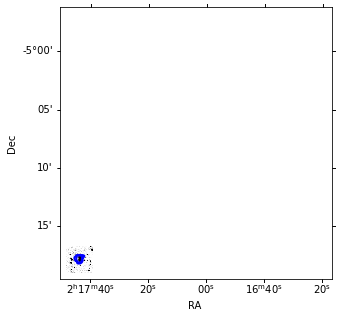

In [252]:
#plot together by using HI coordinates as default and transforming optical coordinates
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111,projection=wcs1.sub([1, 2]))
cmap = cm.Greys
cmap.set_bad('white')
im = ax.imshow(gband_data,transform=ax.get_transform(wcs2.sub([1, 2])), cmap=cmap,  vmin=0, vmax=0.1) #choose vmin and vmax in ds9 
contours = ax.contour(atoms,levels=(1E20,3E20, 5E20, 3E21), colors=['blue'], linewidths=2) #use relevant countour levels
ax.set_xlabel("RA ", fontsize=10)
ax.set_ylabel("Dec", fontsize=10)
#ax.set_xlim(0,100)
#ax.set_ylim(0,100)

#cb = plt.colorbar(mappable=im)
#cb.set_label(r'K kms$^{-1}$')
#cb.add_lines(contours)
#el1 = Ellipse((6, 3), 4.43, 2.85,angle=90+74, edgecolor='black',hatch='//', facecolor='none')
#el2 = Ellipse((35, 6), 14.67/2, 11.3/2,angle=90+18, edgecolor='blue',hatch='//', facecolor='none')
#ax.add_patch(el1)
#ax.add_patch(el2)
#ax.invert_yaxis()  # Flips the Y axi'
#plt.savefig('/Users/apple/astro/HI_on_optical/'+str(cube_name)+'HI_mom0.png',format = 'png',\
 #            bbox_inches = 'tight', transparent=True)
plt.show()